# Predicting Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [11]:
# Importing pandas and numpy
import pandas as pd
import numpy as np
import seaborn as sns
# Reading the csv file into a pandas DataFrame
scores = pd.read_csv('student_data.csv')

# Printing out the first 10 rows of our data
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


In [12]:
scores.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

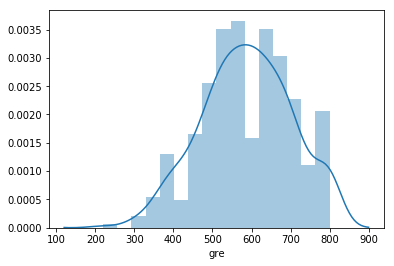

In [13]:
sns.distplot(scores['gre'])

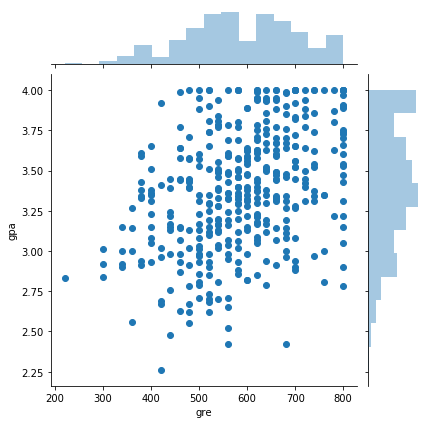

In [16]:
sns.jointplot(x='gre',y='gpa',data=scores,kind='scatter')
#sns.jointplot(x='gre',y='gpa',data=scores,kind='hex')

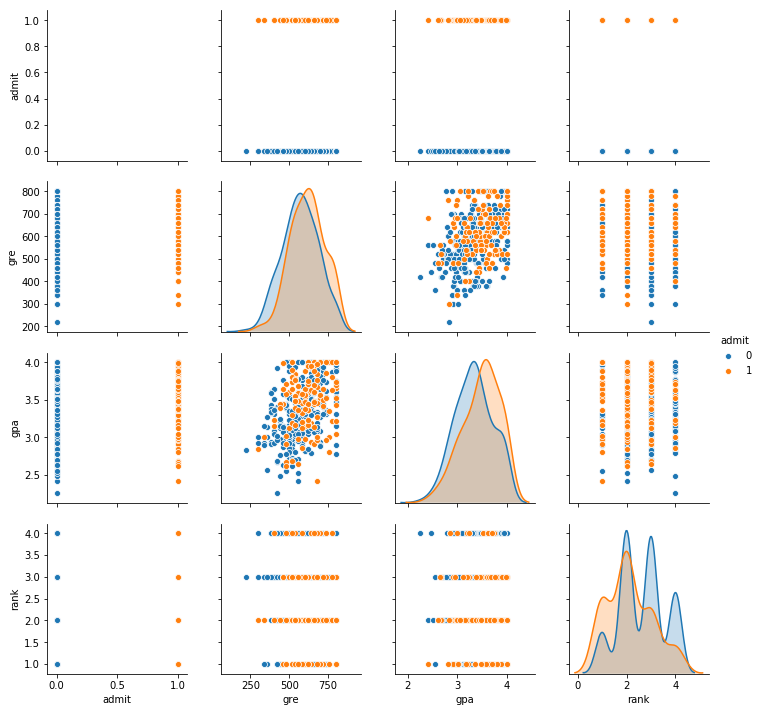

In [25]:
sns.pairplot(data=scores,kind='scatter', hue='admit')

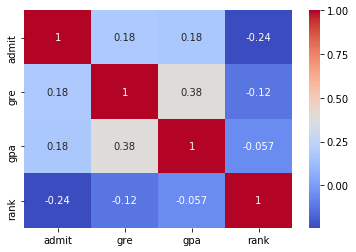

In [22]:
sns.heatmap(scores.corr(),cmap='coolwarm',annot=True)


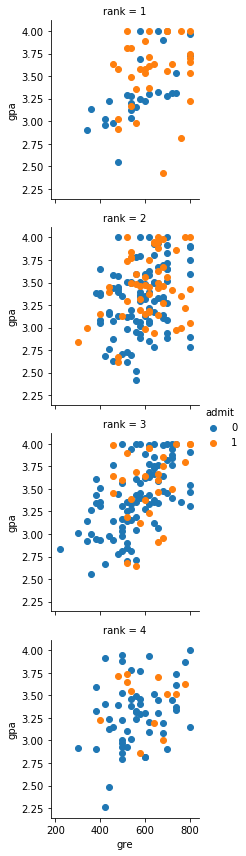

In [27]:
g = sns.FacetGrid(scores, row="rank",hue='admit')
g = g.map(plt.scatter, "gre", "gpa").add_legend()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

# This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## TODO: One-hot encoding the rank
Use the `get_dummies` function in pandas in order to one-hot encode the data.

Hint: To drop a column, it's suggested that you use `one_hot_data`[.drop( )](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [44]:
# TODO:  Make dummy variables for rank and concat existing columns
one_hot_data = pd.concat([scores, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# TODO: Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data.head()

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


## TODO: Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [45]:
# Making a copy of our data
processed_data = one_hot_data[:]

# TODO: Scale the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4

# Printing the first 10 rows of our procesed data
processed_data.head()

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1


## Splitting the data into Training and Testing

In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [51]:
X = processed_data.drop('admit', axis=1)
y = processed_data['admit']

In [53]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: admit, dtype: int64

In [48]:
from sklearn.model_selection import train_test_split 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [ ]:
#below code is original code which is lengthy.manual and not clean

## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

## Training the 2-layer Neural Network
The following function trains the 2-layer neural network. First, we'll write some helper functions.

In [64]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))
def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

# TODO: Backpropagate the error
Now it's your turn to shine. Write the error term. Remember that this is given by the equation $$ (y-\hat{y}) \sigma'(x) $$

In [65]:
# TODO: Write the error term formula
def error_term_formula(x, y, output):
    return (y - output)*sigmoid_prime(x)

In [72]:
# Neural Network hyperparameters
epochs = 1000
learnrate = 0.1

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            error_term = error_term_formula(x, y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(X_train, y_train, epochs, learnrate)

Epoch: 0
Train loss:  0.27571617317941816
Epoch: 1000
Train loss:  0.20772030597432173
Epoch: 2000
Train loss:  0.2063262941510524
Epoch: 3000
Train loss:  0.2057561008167953
Epoch: 4000
Train loss:  0.20537815265181092
Epoch: 5000
Train loss:  0.20505685401664117
Epoch: 6000
Train loss:  0.20476096797606122
Epoch: 7000
Train loss:  0.20448249925099107
Epoch: 8000
Train loss:  0.20421891202019601
Epoch: 9000
Train loss:  0.203968985865761
Finished training!


## Calculating the Accuracy on the Test Data

In [73]:
# Calculate accuracy on test data
test_out = sigmoid(np.dot(X_test, weights))
predictions = test_out > 0.5
accuracy = np.mean(predictions == y_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.683
